#### Jupyter Notebook for importing and plotting ZIP code shapefiles, plotting points from the article 80 and approved datasets, extracting rejected developments from the ZBA dataset, plotting income-based Lorenz curves and finding Gini coefficients for approved and rejected developments by income.

##### Made by Efim Sokolov

#### ZIP code shapes

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as cx # background map
import matplotlib.pyplot as plt

income = gpd.read_file("../data/ZIP_Codes.geojson")

Colormap with unique colors for each ZIP

In [2]:
import distinctipy
n = income["ZIP5"].count()
colors = distinctipy.get_colors(n)
cmap = distinctipy.get_colormap(colors)

#### Approved Dataset

Number of points 607822


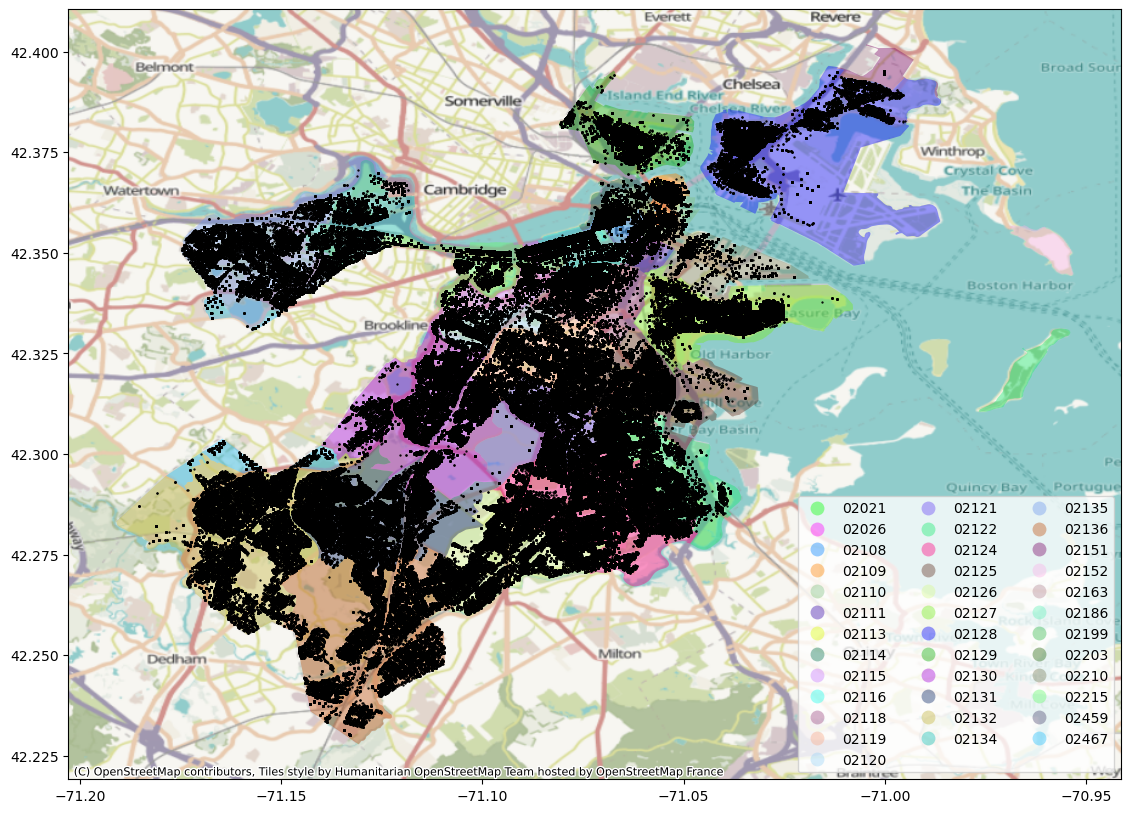

In [4]:
abp = pd.read_csv("../data/cleaned_abp.csv")
abp.dropna(subset=["lon", "lat"], inplace=True)
gabp = gpd.GeoDataFrame(
    abp, geometry=gpd.points_from_xy(abp["lon"], abp["lat"], crs="EPSG:4326")
)
gabp.to_crs(income.crs, inplace=True)
print(f'Number of points {gabp["geometry"].count()}')
ax = income.plot(column="ZIP5", alpha=0.40, categorical=True, legend=True, cmap=cmap, figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 3})
gabp.plot(ax=ax, markersize=0.4, color="k")
cx.add_basemap(ax, crs=income.crs)

#### Article 80 dataset

Number of points 1738


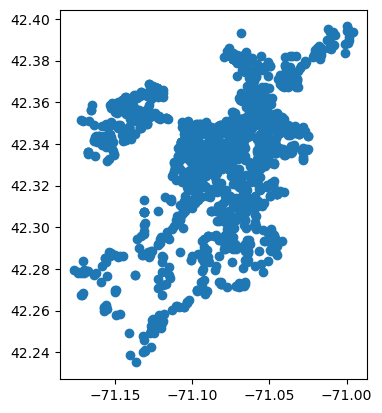

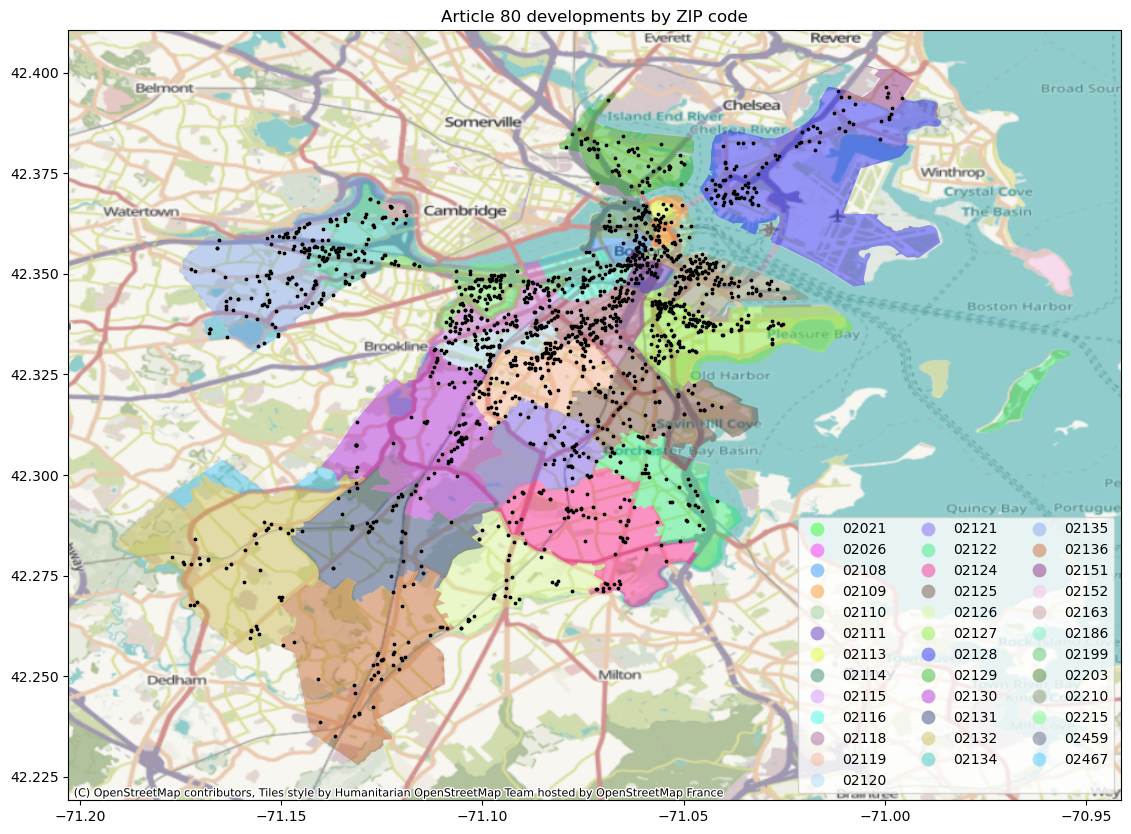

In [5]:
a80 = pd.read_csv("../data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)
income.to_crs("EPSG:4326", inplace=True)
lat_range = (42, 43)
lon_range = (-72, -70)
f_a80 = a80[(a80['lat'] >= lat_range[0]) & (a80['lat'] <= lat_range[1]) &
                   (a80['lon'] >= lon_range[0]) & (a80['lon'] <= lon_range[1])]
fa80 = gpd.GeoDataFrame(
    f_a80, geometry=gpd.points_from_xy(f_a80["lon"], f_a80["lat"], crs="EPSG:4326")
)
fa80.plot()
fa80.to_crs(income.crs, inplace=True)
print(f'Number of points {fa80["geometry"].count()}')
ax = income.plot(column="ZIP5", alpha=0.40, categorical=True, legend=True, cmap=cmap, figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 3})
fa80.plot(ax=ax, markersize=3, color="k")
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Article 80 developments by ZIP code")
plt.savefig("income_zips", bbox_inches='tight')

Spacial Join Developments by ZIP

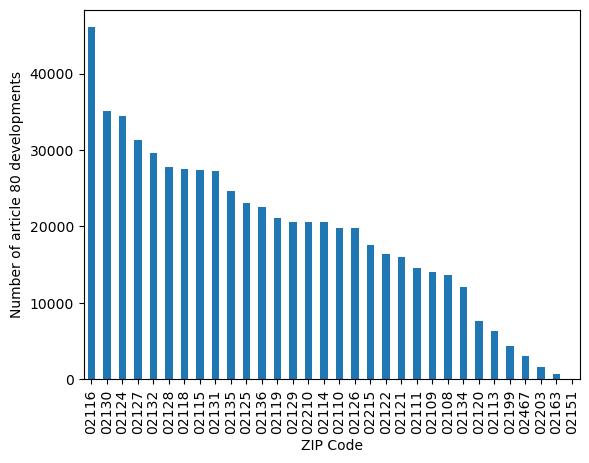

In [6]:
num_per_neighborhood = income.sjoin(gabp, predicate="contains").groupby("ZIP5").size()
ax = num_per_neighborhood.sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel("ZIP Code")
ax.set_ylabel("Number of article 80 developments")
plt.savefig("nums_ZIP", bbox_inches='tight')

Attribute join for the development counts column

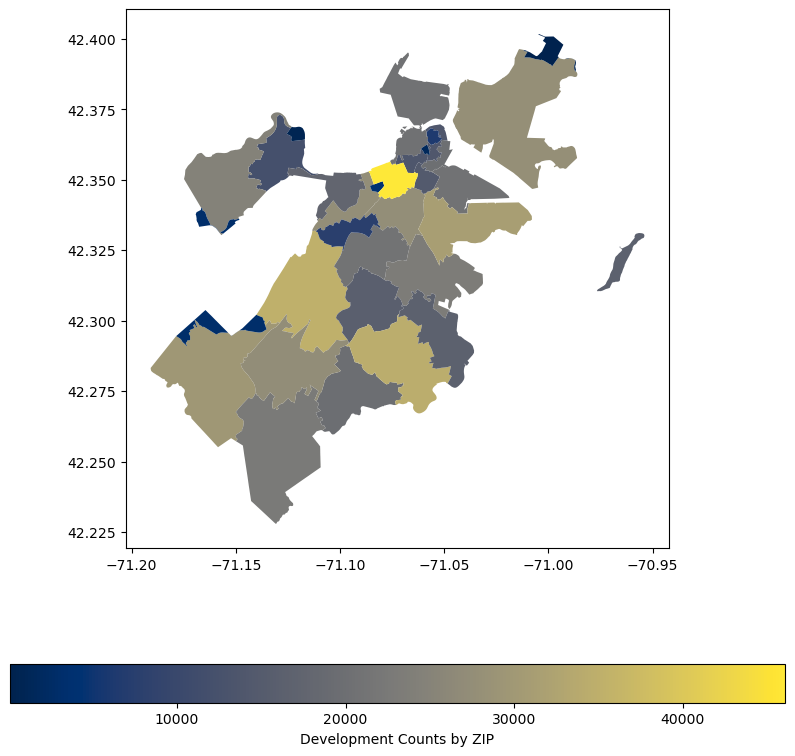

In [7]:
income = income.merge(num_per_neighborhood.rename("Development counts"), left_on="ZIP5", right_on=num_per_neighborhood.index)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
income.plot(column="Development counts", ax=ax, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Development Counts by ZIP",
                         'orientation': "horizontal"})
fig.savefig("income_heat", bbox_inches='tight')

#### ZBA dataset for finding rejected developments

In [8]:
zba = pd.read_csv("../data/raw_zba.csv")

In [9]:
zba["decision"].value_counts()

decision
AppProv       4549
Approved      2392
DeniedPrej     661
Denied         440
Withdrawn      247
                 4
Name: count, dtype: int64

In [10]:
denied = zba[(zba["decision"] == "DeniedPrej") | (zba["decision"] == "Denied")] # rejected

Processing Income data from IRS.csv

In [12]:
def read_IRS(filename):
    data = []
    f = open(filename, "r", encoding="UTF-8")
    for line in f:
        line = line[:-1]
        if line[0] == '1' or line[0] == "2":
            if "under" not in line and "more" not in line:
                data.append("0" + line[:4] + '",' + line[11:-1])
    split_data = []
    for s in data:
        ss = s.split('",')
        if len(ss) == 2:
            s2 = ss[-1].split(',"')
            ss[-1] = s2[0]
            ss.extend(s2[1:])
        split_data.append([int(string.replace('"', '').replace(',', "")) if i != 0 else string for i, string in enumerate(ss)])
    return split_data
data = read_IRS("../data/IRS.csv")
zip_inc = pd.DataFrame(data, columns=["ZIP", "number filed", "amount"])

In [13]:
zip_inc["Average Income"] = zip_inc["amount"] / zip_inc["number filed"]
zip_inc.sort_values(by="Average Income", ascending=False)

ZIP  number filed   amount  Average Income
400  02493          5190  1615196      311.213102
397  02481          6970  1985396      284.848780
277  02030          2840   728897      256.653873
398  02482          4960  1114975      224.793347
392  02468          2710   605529      223.442435
..     ...           ...      ...             ...
223  01840          3390    97643       28.803245
52   01107          4340   122699       28.271659
54   01109         12960   360861       27.844213
224  01841         28250   751227       26.592106
50   01105          4300    95376       22.180465

[480 rows x 4 columns]

In [14]:
income = income.merge(zip_inc, how="left", left_on="ZIP5", right_on="ZIP")

Text(0.5, 1.0, 'Per-capita Income by ZIP Code (in thousands of dollars)')

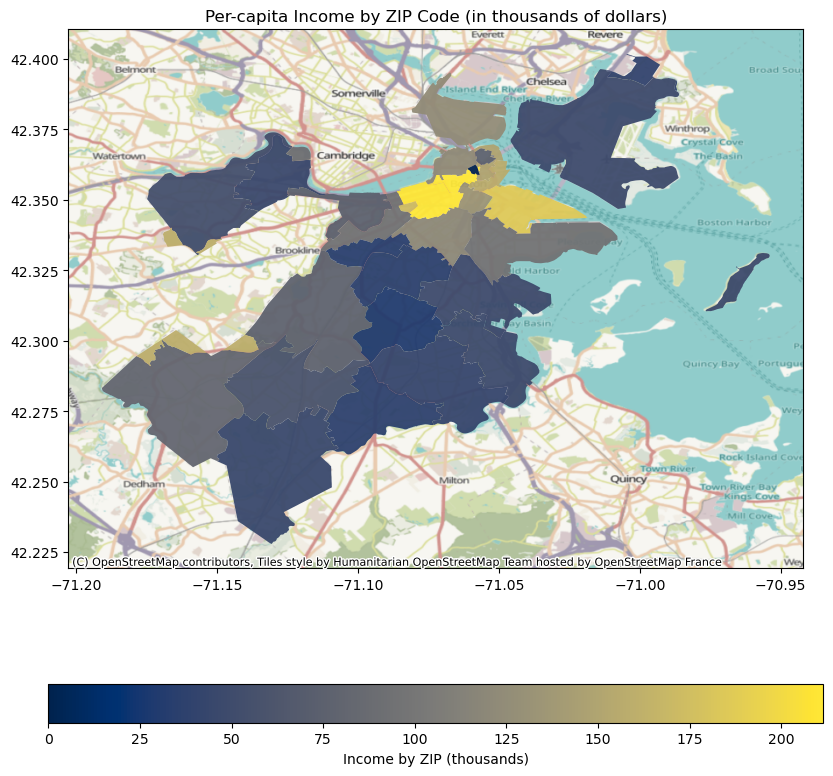

In [15]:
income["Average Income"].fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
income.plot(column="Average Income",ax=ax, alpha=0.95, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Income by ZIP (thousands)",
                         'orientation': "horizontal"})
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Per-capita Income by ZIP Code (in thousands of dollars)")


In [16]:
income.sort_values(by="Average Income", ascending=True, inplace=True)
# Exclude 02203 since no one lives there. City hall ZIP

Population by ZIP dataset

In [26]:
zip_pop = pd.read_csv("../data/Population_by_Income.csv")
r = lambda s: s.replace(",", "")
z = lambda i: "0" + str(i)
zip_pop["Population"] = zip_pop["Population"].apply(r)
zip_pop["Population"] = zip_pop["Population"].apply(int)
zip_pop["ZIP"] = zip_pop["ZIP"].apply(z)

In [27]:
income = income.merge(zip_pop, how="left", left_on="ZIP5", right_on="ZIP")

Text(0.5, 1.0, 'Population')

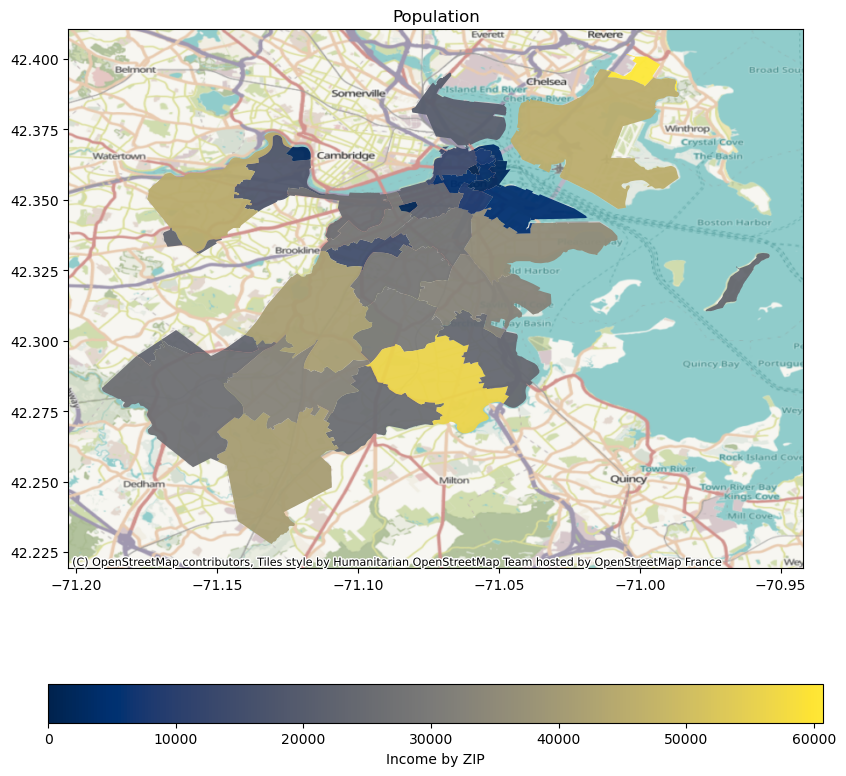

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
income.plot(column="Population",ax=ax, alpha=0.95, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Income by ZIP",
                         'orientation': "horizontal"})
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Population")


In [29]:
zips = zip(income["ZIP5"].to_list(), income["Average Income"].to_list(), income["Development counts"].to_list(), 
           income["Population"].to_list())
zips = list(zips)[1:]

In [30]:
z = pd.DataFrame(zips, columns=["ZIP", "Average Income", "Development Number", "Population"])
sums = {col: z[col].sum() for col in z.columns if col != "ZIP"}
sums

{'Average Income': 3858.2000267355543,
 'Development Number': 624489,
 'Population': 892163}

#### Overall Income Gini for Boston

Text(0.5, 1.0, 'Income-population Lorenz Curve for Boston')

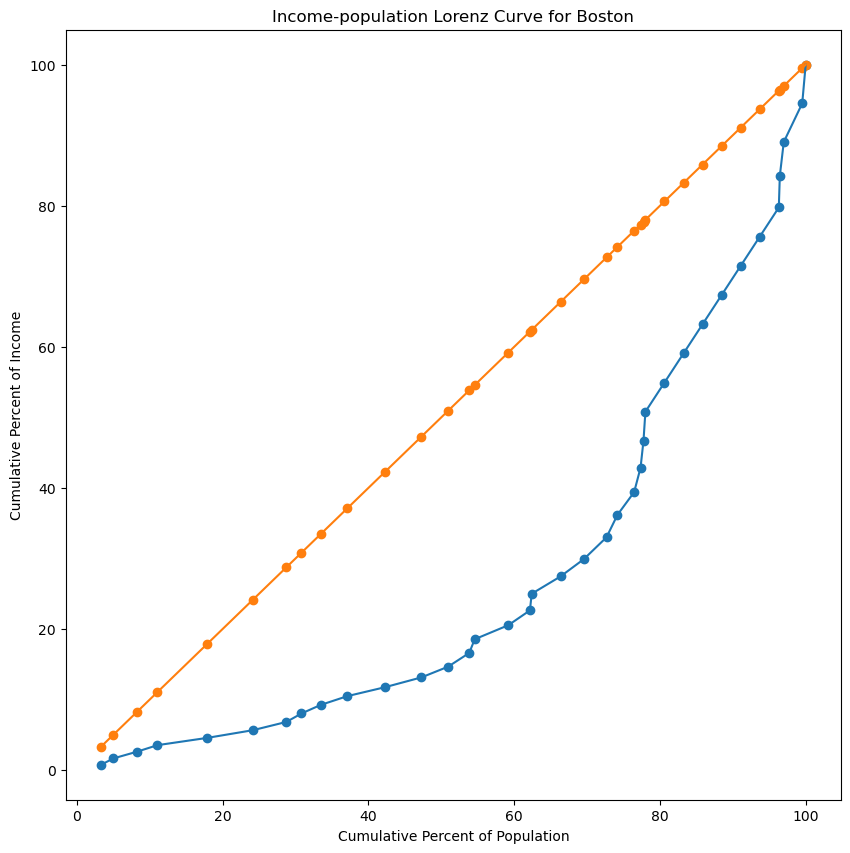

In [31]:
z.sort_values(by="Average Income", ascending=True, inplace=True)
sum_pop, sum_inc = 0, 0
ratios_pop, ratios_inc = [], []
for i, row in z.iterrows():
    sum_pop += row["Population"]
    sum_inc += row["Average Income"]
    r_pop = sum_pop / sums["Population"]
    r_inc = sum_inc / sums["Average Income"]
    ratios_pop.append(r_pop * 100)
    ratios_inc.append(r_inc * 100)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_inc)
ax.scatter(ratios_pop, ratios_inc)
ax.plot(ratios_pop, ratios_pop)
ax.scatter(ratios_pop, ratios_pop)
ax.set_ylabel("Cumulative Percent of Income")
ax.set_xlabel("Cumulative Percent of Population")
ax.set_title("Income-population Lorenz Curve for Boston")

Gini coefficient

In [32]:
from sklearn.metrics import auc
lorenz = auc(ratios_pop, ratios_inc)
full = 5000
gini = (full - lorenz) / full
gini

0.47991324874398844

Slightly worse than the US Gini of 0.47

#### Lorenz curv for approved requests by income

Text(0.5, 1.0, 'Lorenz Curve for Approved Requests by Income')

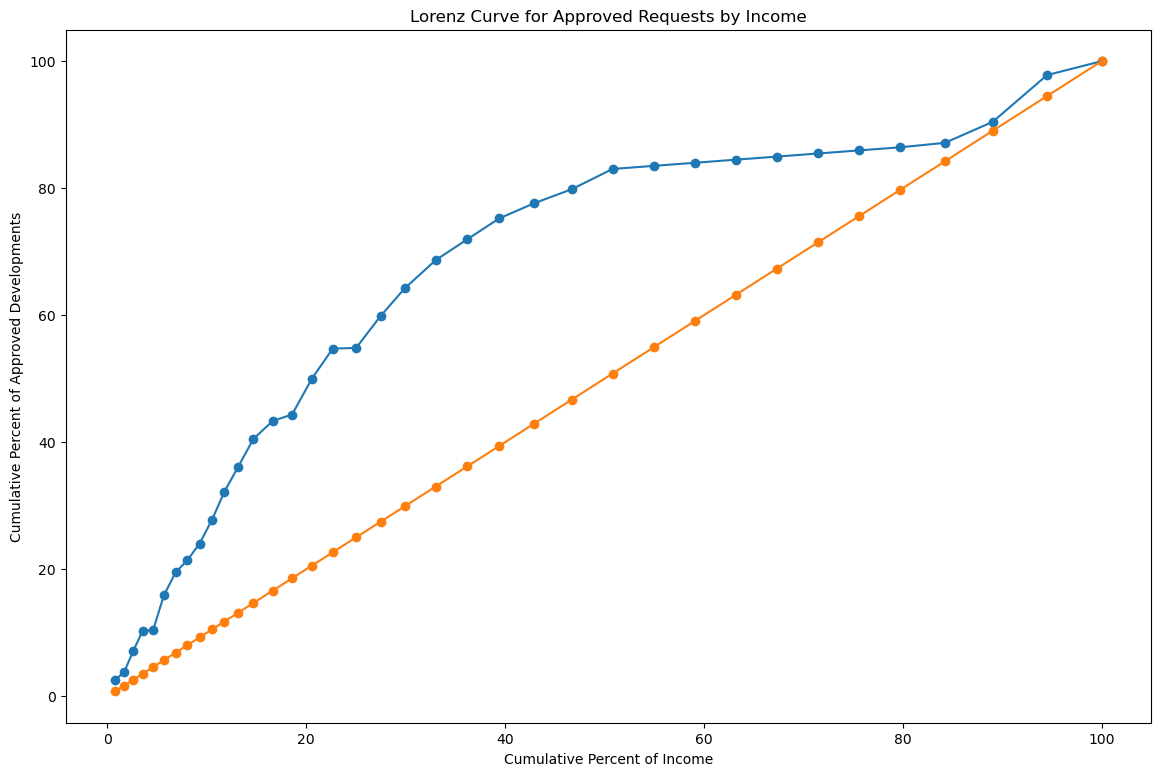

In [33]:
sum_inc, sum_dev = 0, 0
ratios_inc, ratios_dev = [], []
z.sort_values(by="Average Income", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_inc += row["Average Income"]
    sum_dev += row["Development Number"]
    r_inc = sum_inc / sums["Average Income"]
    r_dev = sum_dev / sums["Development Number"]
    ratios_inc.append(r_inc * 100)
    ratios_dev.append(r_dev * 100)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(ratios_inc, ratios_dev)
ax.scatter(ratios_inc, ratios_dev)
ax.plot(ratios_inc, ratios_inc)
ax.scatter(ratios_inc, ratios_inc)
ax.set_xlabel("Cumulative Percent of Income")
ax.set_ylabel("Cumulative Percent of Approved Developments")
ax.set_title("Lorenz Curve for Approved Requests by Income")

Gini coefficient (negative since skewed towards lower income values)

In [34]:
lorenz = auc(ratios_inc, ratios_dev)
full = 5000
gini = (full - lorenz) / full
gini

-0.39506614201476914

Lorenz curve development number vs population by ZIP

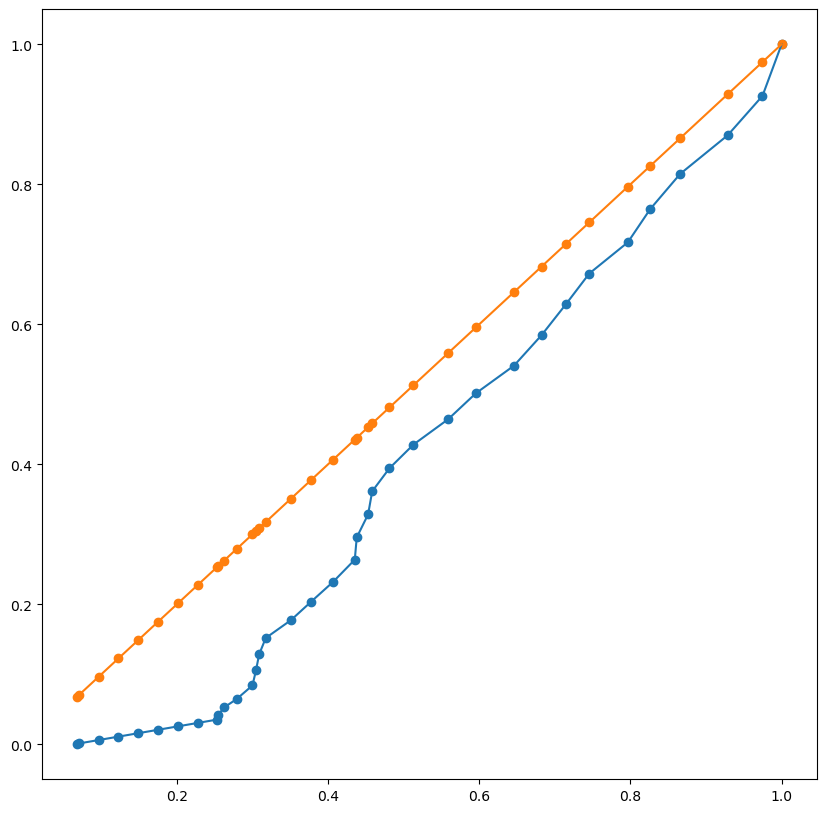

In [35]:
sum_pop, sum_dev = 0, 0
ratios_pop, ratios_dev = [], []
z.sort_values(by="Development Number", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_pop += row["Population"]
    sum_dev += row["Development Number"]
    r_pop = sum_pop / sums["Population"]
    r_dev = sum_dev / sums["Development Number"]
    ratios_pop.append(r_pop)
    ratios_dev.append(r_dev)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_dev)
ax.scatter(ratios_pop, ratios_dev)
ax.plot(ratios_pop, ratios_pop)
ax.scatter(ratios_pop, ratios_pop)

#### Extracting denied developments

In [36]:
denied["ZIP"]= denied["zip"].apply(lambda i: "0" + str(i))

C:\Users\lukas\AppData\Local\Temp\ipykernel_11440\1681722881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denied["ZIP"]= denied["zip"].apply(lambda i: "0" + str(i))


In [37]:
denied_counts = denied.groupby("zip")["decision"].count()
denied_counts.index= ["0" + str(i) for i in denied_counts.index]
len(denied_counts.index)

26

In [38]:
den_income = income[income["ZIP5"].isin(denied_counts.index)]

In [39]:
z = den_income.merge(denied_counts, how="left", left_on="ZIP5", right_on=denied_counts.index)
z.rename(columns={"decision": "denied counts"}, inplace=True)

In [40]:
sums_2 = {}
sums_2["denied counts"] = z["denied counts"].sum()
sums_2["Average Income"] = z["Average Income"].sum()
sums_2

{'denied counts': 1101, 'Average Income': 2252.135597989934}

Lorenz curve for rejected developments

Text(0.5, 1.0, 'Lorenz Curve for Rejected Requests by Income')

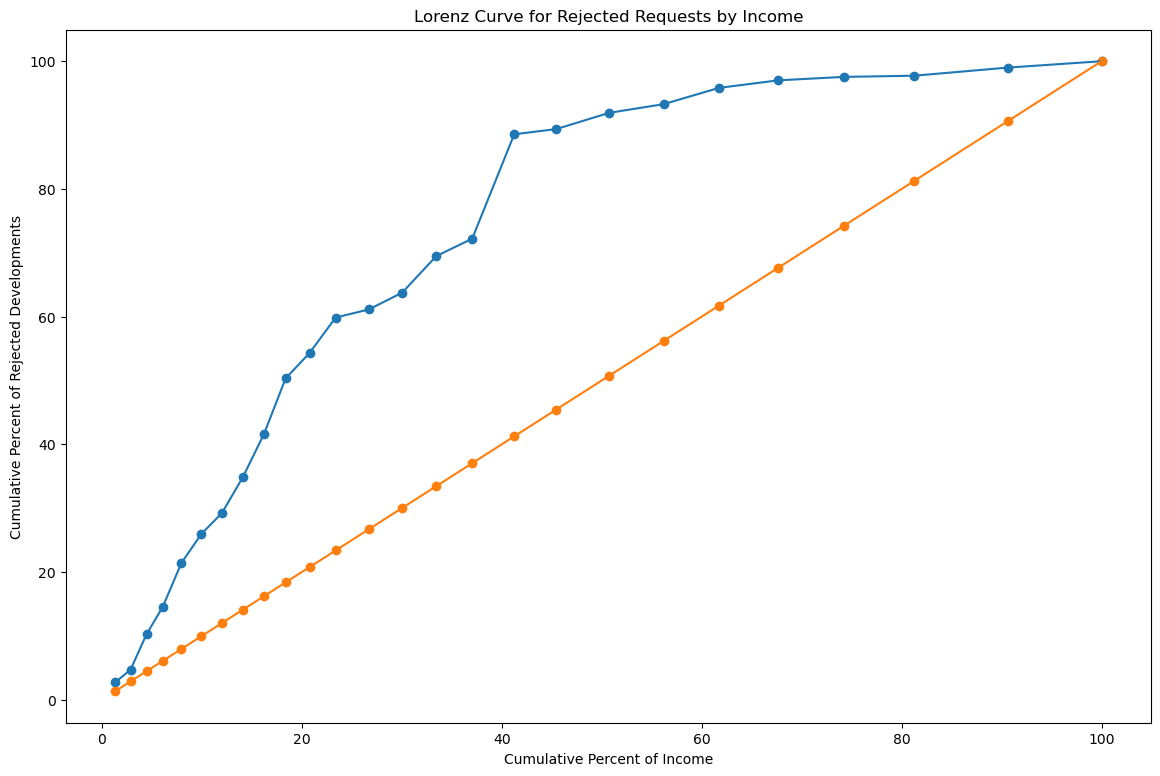

In [41]:
sum_inc, sum_dev = 0, 0
ratios_inc, ratios_dev = [], []
z.sort_values(by="Average Income", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_inc += row["Average Income"]
    sum_dev += row["denied counts"]
    r_inc = sum_inc / sums_2["Average Income"]
    r_dev = sum_dev / sums_2["denied counts"]
    ratios_inc.append(r_inc * 100)
    ratios_dev.append(r_dev * 100)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(ratios_inc, ratios_dev)
ax.scatter(ratios_inc, ratios_dev)
ax.plot(ratios_inc, ratios_inc)
ax.scatter(ratios_inc, ratios_inc)
ax.set_xlabel("Cumulative Percent of Income")
ax.set_ylabel("Cumulative Percent of Rejected Developments")
ax.set_title("Lorenz Curve for Rejected Requests by Income")

In [42]:
lorenz = auc(ratios_inc, ratios_dev)
full = 5000
gini = (full - lorenz) / full
gini

-0.5117853118156045

In [43]:
list(zip(ratios_inc, ratios_dev))

[(1.335256524332415, 2.7247956403269753),
 (2.8738042561095827, 4.72297910990009),
 (4.468093669602605, 10.263396911898274),
 (6.0862186560356175, 14.532243415077204),
 (7.958080479185413, 21.435059037238872),
 (9.962372755602908, 25.9763851044505),
 (12.011897525082764, 29.246139872842868),
 (14.108418131793524, 34.87738419618528),
 (16.237224153810402, 41.689373297002724),
 (18.376204736252422, 50.31789282470481),
 (20.78102524437175, 54.31425976385105),
 (23.37888623082312, 59.85467756584922),
 (26.708384156271336, 61.12624886466848),
 (30.044473355085216, 63.76021798365122),
 (33.45112537334408, 69.48228882833789),
 (37.04607030272663, 72.20708446866485),
 (41.24688687817164, 88.5558583106267),
 (45.44832408833345, 89.3732970027248),
 (50.74936170305349, 91.9164396003633),
 (56.19946615769672, 93.2788374205268),
 (61.72173547096269, 95.8219800181653),
 (67.63703632251281, 97.00272479564033),
 (74.2268570351585, 97.54768392370572),
 (81.22985590913618, 97.72933696639419),
 (90.61188

Bottom 50% accounts for 92% of denied decisions.